# Spatial correlation analysis - ERA5

* This notebook shows how spatial correlation was computed for upper air variables in ERA5.

* The notebook runs with `verif_config_6h.yml` in the same folder.

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
from scipy.stats import pearsonr
from itertools import combinations

sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu

### Load config

In [3]:
config_name = os.path.realpath('verif_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [4]:
verif_ind_start = 0; verif_ind_end = 4*(365+366+365)

path_verif = conf['ERA5_ours']['save_loc_verif']+'spatial_corr_{:04d}_{:04d}_ERA5.nc'.format(
    verif_ind_start, verif_ind_end)

### Spatial correlation compute

In [5]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filename_ERA5 = sorted(glob(conf['ERA5_ours']['save_loc']))

# pick years
year_range = conf['ERA5_ours']['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')
    
# select variables
variables_levels = {'V': None, 'U': None, 'T': None, 'Q': None}
ds_ERA5_merge = vu.ds_subset_everything(ds_ERA5_merge, variables_levels)

# get level information
levels = ds_ERA5_merge['level'].values

# ---------------------------------------------------------------------------------------- #
# allocate spatial corrlation on every 6 hour
corr_ds_list = []

# variables (time, level, latitude, longtude) to compute corr
var_4D = list(variables_levels.keys())

# loop over 6 hourly indices
for i_time in range(verif_ind_start, verif_ind_end):
    
    ds_target = ds_ERA5_merge.isel(time=i_time).load()
    
    # create a list of var with level info
    var_info = [(f"{varname}_{level_num}", varname, level_num) for varname in var_4D for level_num in levels]
    
    # get var names to label output xarray
    varname_full = [var[0] for var in var_info]
    N_vars = len(varname_full)
    
    # allocate xr.DataArray for corr output
    corr_array = xr.DataArray(
        np.full((N_vars, N_vars), np.nan),
        coords={'var1': varname_full, 'var2': varname_full},
        dims=['var1', 'var2']
    )

    # loop over variable pairs, compute corr
    for (var1_info, var2_info) in combinations(var_info, 2):
        
        # var1
        varname1, var1, lev1 = var1_info
        data_target1 = ds_target[var1].sel(level=lev1)

        # var2
        varname2, var2, lev2 = var2_info
        data_target2 = ds_target[var2].sel(level=lev2)
        
        # convert to numpy and ravel
        data_target1 = data_target1.values.ravel()
        data_target2 = data_target2.values.ravel()

        # corr
        corr, _ = pearsonr(data_target1, data_target2)
        
        # assign corr coef to corr_array
        corr_array.loc[dict(var1=varname1, var2=varname2)] = corr
        corr_array.loc[dict(var1=varname2, var2=varname1)] = corr

    # set diagonal elements to 1
    for varname in varname_full:
        corr_array.loc[dict(var1=varname, var2=varname)] = 1.0

    # convert xr.DataArray to xr.Dataset
    corr_ds = xr.Dataset({'correlation': corr_array})

    # Append the dataset to the list
    corr_ds_list.append(corr_ds)

# concat all 6 hourly result
corr_ds_combined = xr.concat(corr_ds_list, dim='day')
#corr_ds_combined.to_netcdf(path_verif)

### Plot

In [7]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data_plot = np.array(corr_ds_combined['correlation'])[1, ...]

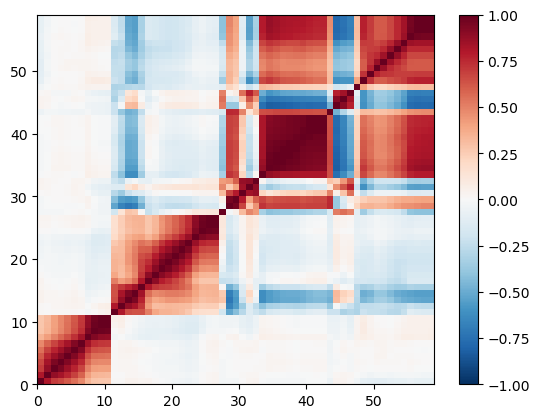

In [9]:
plt.pcolormesh(data_plot[5:, 5:], vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
plt.colorbar()  # Optional: Adds a colorbar